In [27]:
#import modules
from numpy import array
from math import sqrt
from itertools import chain
#nlp text processing dependencies
import re
import string
import inflector
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
#word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

#pyspark dependencies
import pyspark
from pyspark.sql.functions import *
from pyspark.mllib.clustering import KMeans
from pyspark.context import SparkContext
from pyspark import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Word2Vec,CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType, Row


In [7]:
#define spark context
spark = SparkSession\
        .builder\
        .appName("SentimentAnalysis")\
        .getOrCreate()

sc = spark.sparkContext



In [28]:
sqlContext = SQLContext(sc)

In [10]:
# load csv data
raw_dataframe = spark.read.format("csv") \
.option("header", "true") \
.load("/Users/agarwalshruti28/Downloads/Twitter\ Analysis/coronavirus-covid19-tweets/2020-03-12\ Coronavirus\ Tweets.CSV")

#print Schema
raw_dataframe.printSchema()


root
 |-- status_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- reply_to_status_id: string (nullable = true)
 |-- reply_to_user_id: string (nullable = true)
 |-- reply_to_screen_name: string (nullable = true)
 |-- is_quote: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- favourites_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- place_full_name: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- account_lang: string (nullable = true)
 |-- account_created_at: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- lang: string (nullable = true)



In [11]:
#register temp table for sql usage
raw_dataframe.registerTempTable("raw_dataframe")

In [12]:

# filter only english tweets and get status_id and text for pr
english_tweets_raw = spark.sql("""SELECT status_id, text

                     FROM raw_dataframe
                     
                     WHERE lang="en"
                   """ )



In [13]:
# top 20 rows
english_tweets_raw.show()

+-------------------+--------------------+
|          status_id|                text|
+-------------------+--------------------+
|1237891051307896832|Tonight: Wednesda...|
|1237891052159119366|No, but seriously...|
|1237891052779884545|To help those in ...|
|1237891053182738432|Today in the ente...|
|1237891053686075392|This JAMA Insight...|
|1237891054600241152|Watch this newly ...|
|1237891054721880067|Think about alter...|
|1237891054797352964|With 200 colleges...|
|1237891055199981578|Get the latest on...|
|1237891055502020612|Do you trust your...|
|1237891060879118337|Shocking X-ray im...|
|1237891072358903813|This is a stagger...|
|1237891073503944705|Fucking moron #Wo...|
|1237891074539974665|University of Cop...|
|1237891075445903363|5 Pack Face Masks...|
|1237891075970412545|Aye @realDonaldTr...|
|1237891078105284608|Small gadget to f...|
|1237891079057190913|On https://t.co/p...|
|1237891085281546240|As a mom, I’ve ca...|
|1237891087764619266|$ALT -IMO with on...|
+----------

In [14]:
#total number of english tweets
english_tweets_raw.count()

167449

In [15]:
english_tweets_raw.select('text').show(1,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Tonight: Wednesday, March 11, join us for our latest #coronavirus 

In [16]:
def get_usernames_from_tweet(text):
    usernames=re.findall(r"(?<=@)\w+", text)
    return usernames

In [17]:
#define python functions as pysaprk sql
get_usernames_from_tweet_udf=udf(lambda text: get_usernames_from_tweet(text), ArrayType(StringType()))

In [18]:
english_tweets_processed=english_tweets_raw.withColumn('usernames',get_usernames_from_tweet_udf('text'))

In [19]:
english_tweets_processed.show(10,truncate=False)

+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------+
|status_id          |text                                                                                                                                                                                                                                                                                                                |usernames                                                    |
+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
def get_hashtags_from_tweet(text):
    hashtags=re.findall(r"#(\w+)", text)
    return hashtags

In [21]:
#define python functions as pysaprk sql
get_hashtags_from_tweet_udf=udf(lambda text: get_hashtags_from_tweet(text), ArrayType(StringType()))

In [22]:
english_tweets_processed=english_tweets_processed.withColumn('hashtags',get_hashtags_from_tweet_udf('text'))

In [23]:
english_tweets_processed.show(10,truncate=False)

+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------+------------------------------------------------------+
|status_id          |text                                                                                                                                                                                                                                                                                                                |usernames                                                    |hashtags                                              |
+-------------------+-----------------------------------------------------------------------------------

In [29]:
username_df=english_tweets_processed.select('usernames').agg(flatten(collect_list("usernames"))).withColumn("size",size('flatten(collect_list(usernames))'))
username_array=username_df.select('flatten(collect_list(usernames))').rdd.flatMap(lambda x: chain(*x)).map(lambda x: [Row(y) for y in [x] ]).map(lambda x: x[0]).collect()
username_array_temp=sc.parallelize(username_array)
username_df=sqlContext.createDataFrame(username_array_temp,['usernames'])

In [30]:
username_df.groupby('usernames').count().sort(desc("count")).show(10)

+---------------+-----+
|      usernames|count|
+---------------+-----+
|realDonaldTrump| 5625|
|   BorisJohnson| 1136|
|            WHO|  938|
|       JoeBiden|  818|
|            NBA|  799|
|          POTUS|  745|
|       tomhanks|  717|
|            GOP|  545|
|         CDCgov|  540|
|            CNN|  475|
+---------------+-----+
only showing top 10 rows



In [31]:
hashtags_df=english_tweets_processed.select('hashtags').agg(flatten(collect_list("hashtags"))).withColumn("size",size('flatten(collect_list(hashtags))'))
hashtags_array=hashtags_df.select('flatten(collect_list(hashtags))').rdd.flatMap(lambda x: chain(*x)).map(lambda x: [Row(y) for y in [x] ]).map(lambda x: x[0]).collect()
hashtags_array_temp=sc.parallelize(hashtags_array)
hashtags_df=sqlContext.createDataFrame(hashtags_array_temp,['hashtags'])

In [32]:
hashtags_df.groupby('hashtags').count().sort(desc("count")).show(10)

+-------------------+-----+
|           hashtags|count|
+-------------------+-----+
|CoronavirusPandemic|80073|
|           Covid_19|52368|
|            COVID19|37160|
|        coronavirus|18589|
|  CoronaVirusUpdate|10368|
|     CoronaOutbreak| 5306|
|CoronavirusOutbreak| 4823|
|            covid19| 4649|
|             COVD19| 4393|
|        Coronavirus| 3684|
+-------------------+-----+
only showing top 10 rows



In [33]:
top_10_hashtags=hashtags_df.groupby('hashtags').count().sort(desc("count")).limit(100).toPandas()
top_10_usernames=username_df.groupby('usernames').count().sort(desc("count")).limit(100).toPandas()

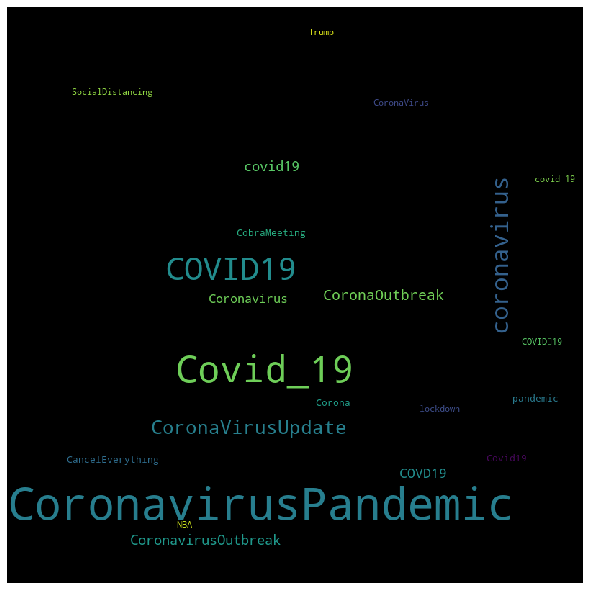

In [34]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 12).generate_from_frequencies(top_10_hashtags.set_index("hashtags").to_dict()['count'])
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

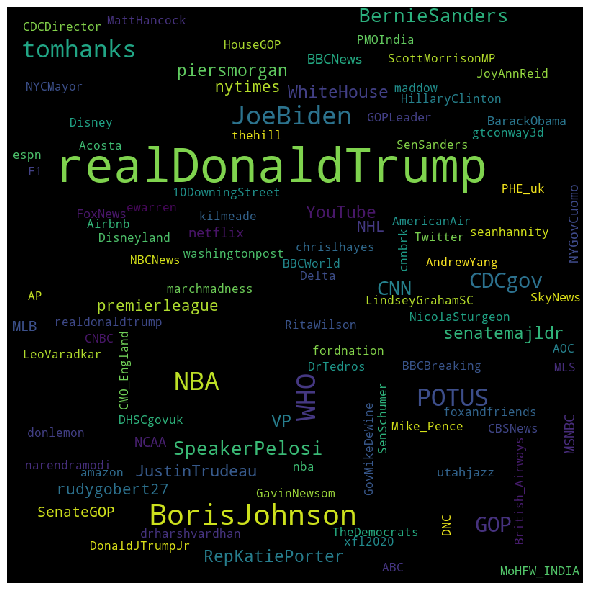

In [35]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 12).generate_from_frequencies(top_10_usernames.set_index("usernames").to_dict()['count'])
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
# hashtags nikaale
# username nikaale using regular expression and pyspark udf function
# groupby kakre freq nikali hashtags ki aur fir usernsame ki
# top 100 words ka word cloud banaya,picture
